# OpenWrt SysUpgrade

    本文档简述了openwrt sdk的升级功能流程，从页面传入升级文件到升级文件检测，再到调用升级脚本进行升级，升级完成后，进行系统重启。最后简述了如何添加升级文件标识，标识包括自己定义的字段，以及升级软件的md5值。达到防止用户用其他openwrt sdk编译出来的固件刷新我们的系统，以及防止升级软件被破坏。

    文档需要用到的文件及在sdk中的路径（某些文件路径可能随项目的不同而改动）：
    ./package/ralink/ui/luci-mtk/src/modules/admin-full/luasrc/controller/admin/system.lua
    ./target/linux/ramips/image/ Makefile
    ./package/base-files/files/lib/upgrade/common.sh
    ./package/base-files/files/lib/functions.sh
    ./package/base-files/files/sbin/sysupgrade
    ./target/linux/ramips/base-files/lib/ramips.sh
    ./target/linux/ramips/base-files/lib/upgrade/platform.sh

## 从页面接受传过来的升级文件

    作为整个流程的开始，功能实现在文件system.lua中。
    
    这是一个lua文件，很容易在function index函数中找到系统升级功能的入口函数：action_flashops。在这个函数中首先通过fp = io.open(image_tmp, “w”)打开升级临时文件：/tmp/firmware.img. 打开后通过fp.write(chunk)写入页面传进来的升级文件。到这里，接受升级文件完成 。

## 检测升级文件的合法性

    实现同样在文件system.lua中。
    
    在函数image_supported()中进行检测，这个函数通过image magic number来检测升级文件是否合法。函数image_supported()会调用platform.sh脚本中的platform_check_image函数，platform_check_image函数调用ramips.sh脚本中的ramips_board_name函数，获取board name，ramips_board_name函数从文件 /tmp/sysinfo/board_name 中获取board name，若没有则为unknown，并返回给调用者，我用的板是ralink-soc。platform_check_image函数继续调用common.sh脚本中的get_magic_long函数，用以获取升级文件magic，就是升级文件前4位。get_magic_long函数调用common.sh脚本中的get_image函数用以获取文件/tmp/firmware.img内容，其实就是cat /tmp/firmware.img. 获取到的内容，通过dd bs=4 count=1，来获取前4位，最后通过hexdump -v -n 4 -e ‘1/1 “%02x”‘处理以十六进制编码返回调用者。获取到的升级文件magic，在platform_check_image函数中与27051956做对比，这个值是在固件编译的时候已经定好了的。如果相等，就是合法的升级文件，继续升级动作；不相等则为非法升级文件，做一些后续处理并终止升级动作。到这里检测升级文件合法性完成。

## 检测升级文件不合法后的处理

    实现同样在文件system.lua中。
    
    检测到不合法后，通过nixio.fs.unlink(image_tmp)来删除临时文件/tmp/firmware.img，并通过image_invalid = true，设置检测失败，用以通知页面显示提示信息。终止升级。处理完成。

## 检测升级文件合法后的处理

    实现同样在文件system.lua中。
    
    检测到升级文件合法后，会获取一些升级文件相关的信息，用以在页面显示：调用image_checksum()，获取checksum；调用storage_size()，获取可用空间大小；调用nixio.fs.stat(image_tmp).size，获取升级文件大小；以及页面传过来的是否保存配置的值；其中，image_checksum()函数用的是md5sum命令，storage_size()函数是在系统文件/proc/mtd中找到firmware分区大小。
    
    接下来如果用户选择进行升级文件，则会现在页面上打印一些提示信息，用于提示用户：正在升级，不要断开电源等等。
    
    文件system.lua最后的处理就是调用升级脚本：
    fork_exec("killall dropbear uhttpd; sleep 1; /sbin/sysupgrade %s %q" %{ keep, image_tmp })
    这条语句，先清除dropbear 和uhttpd进程，再等待1秒，最后调用升级脚本sysupgrade，传过去的参数就是keep：是否要保存配置；image_tmp：升级文件/tmp/firmware.img。
    OK，到这里system.lua文件中关于升级前的准备工作都完成了，视线请转到升级脚本sysupgrade上。

## 运行升级脚本sysupgrade

    实现在文件sysupgrade中。
    
    脚本开始，像所有的主体处理程序一样，会对传进来的参数进行处理。下面对这些参数的介绍：
    -i 开启交互模式
    -d 重启前延迟，延迟秒数是传进来的
    -v 会打印sysupgrade脚本中的一些信息，脚本中默认打印
    -q 与-v相反
    -n 升级后不保存配置，默认保存配置
    -c 保存所有的改动配置文件到/etc/
    -b 用sysupgrade.conf中指定的文件，创建.tar.gz格式备份文件
    -r 用上步创建的.tar.gz文件，恢复配置
    -l 列出将会备份的文件列表
    -f 从.tar.gz恢复配置
    -F 即使升级文件检测失败，也要升级，这个参数是危险的，慎用
    -T 验证升级文件和.tar.gz配置文件，但不升级
    -h 打印帮助信息

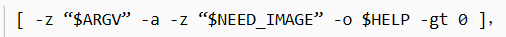

In [1]:
from IPython.display import Image
Image(filename='./sysupgrade1.png', width=650, height=600)

    意思是：如果没有升级文件参数，且没有命令行参数-b（create-backup)，-r（restore-backup），或者带有-h（help）参数，则打印帮助信息。这个条件为真的话，会在终端打印帮助信息，退出脚本。

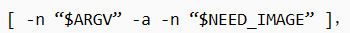

In [2]:
from IPython.display import Image
Image(filename='./sysupgrade2.png', width=650, height=600)

    意思是：不要指定-b或-r（创建配置、恢复配置）的同时，指定升级文件。为真的话，打印提示信息，退出脚本。

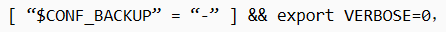

In [3]:
from IPython.display import Image
Image(filename='./sysupgrade3.png', width=650, height=600)

    意思是：选择备份配置但传进来的文件为“-”时，不打印备份文件时的过程。
    
    下面展示一下-v选项的作用, 带-v时的升级过程：
    root@OpenWrt:/# sysupgrade -i -v /tmp/firmware.img
    Keep config files over reflash (Y/n): y
    Edit config file list (y/N): n
    Saving config files...
    etc/config/dhcp
    etc/config/dropbear
    etc/config/firewall
    etc/config/fstab
    etc/config/luci
    etc/config/network
    etc/config/system
    etc/config/ucitrack
    etc/config/uhttpd
    etc/config/wireless
    etc/dropbear/dropbear_dss_host_key
    etc/dropbear/dropbear_rsa_host_key
    etc/group
    etc/hosts
    etc/inittab
    etc/passwd
    etc/profile
    etc/rc.local
    etc/shells
    etc/sysctl.conf
    Sending TERM to remaining processes ... dnsmasq ubusd btnd logd netifd uhttpd ntpd
    Sending KILL to remaining processes ...
    Switching to ramdisk...
    Performing system upgrade...
    Unlocking firmware ...
    Writing from <stdin> to firmware ...     
    Appending jffs2 data from /tmp/sysupgrade.tgz to firmware...
    Writing from <stdin> to firmware ...     
    Upgrade completed
    Reboot (Y/n):

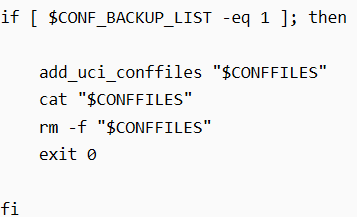

In [10]:
from IPython.display import Image
Image(filename='./sysupgrade4.png', width=500, height=500)

    如果需要列出配置文件列表，就调用add_uci_conffiles函数生成列表，并打印到终端。函数add_uci_conffiles()，找出需要保存的配置文件。通过在文件/etc/sysupgrade.conf中 ，/lib/upgrade/keep.d/*目录下，以及命令opkg list-changed-conffiles的输出中，找出配置 文件，其中opkg list-changed-conffiles 列出用户修改的配置文件.

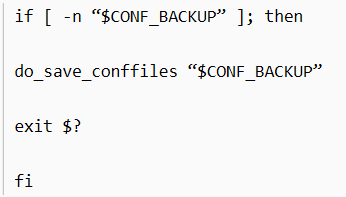

In [13]:
from IPython.display import Image
Image(filename='./sysupgrade5.png', width=450, height=450)

    如果需要创建配置备份文件，则调用函数do_save_conffiles，生成配置文件。函数do_save_conffiles()，打包上一步列出的配置文件 。

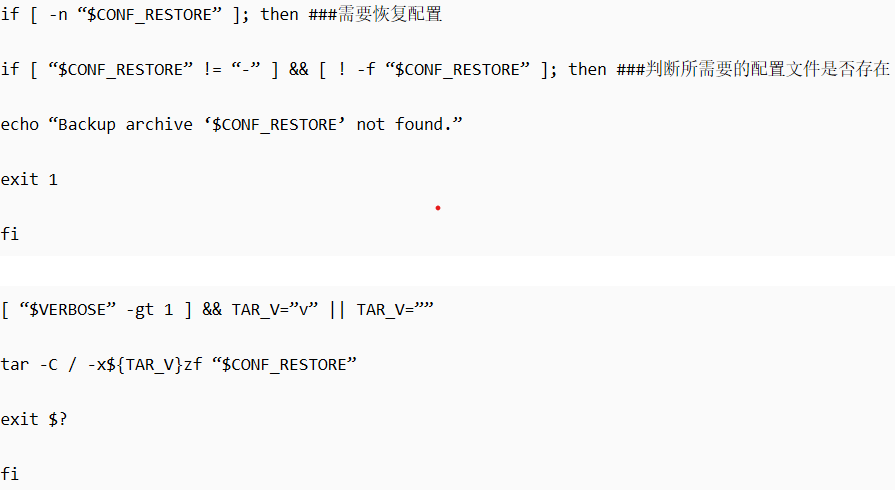

In [16]:
from IPython.display import Image
Image(filename='./sysupgrade6.png', width=800, height=800)

    经过一些判断，解压配置文件包。

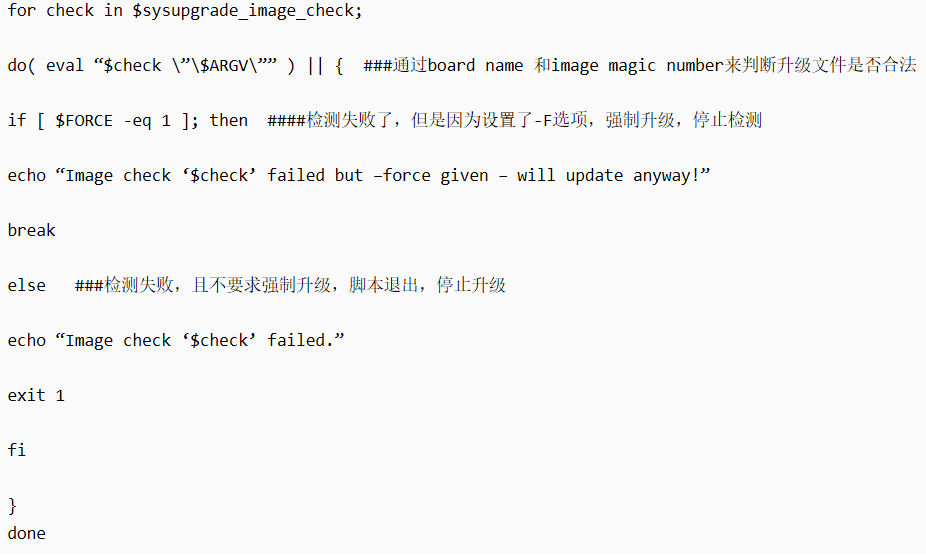

In [17]:
from IPython.display import Image
Image(filename='./sysupgrade7.png', width=800, height=800)

    type platform_check_image，检测platform_check_image命令是否存在，为了下步做准备。找不到的话，脚本退出，升级终止。
    
    做升级文件的检测，sysupgrade_image_check就是platform_check_image，这个检测在升级开始的时候已经做过了，这里又做了一遍。如果检测失败了，但是设置了-F选项，强制升级，如果没设置，就脚本退出，停止升级。

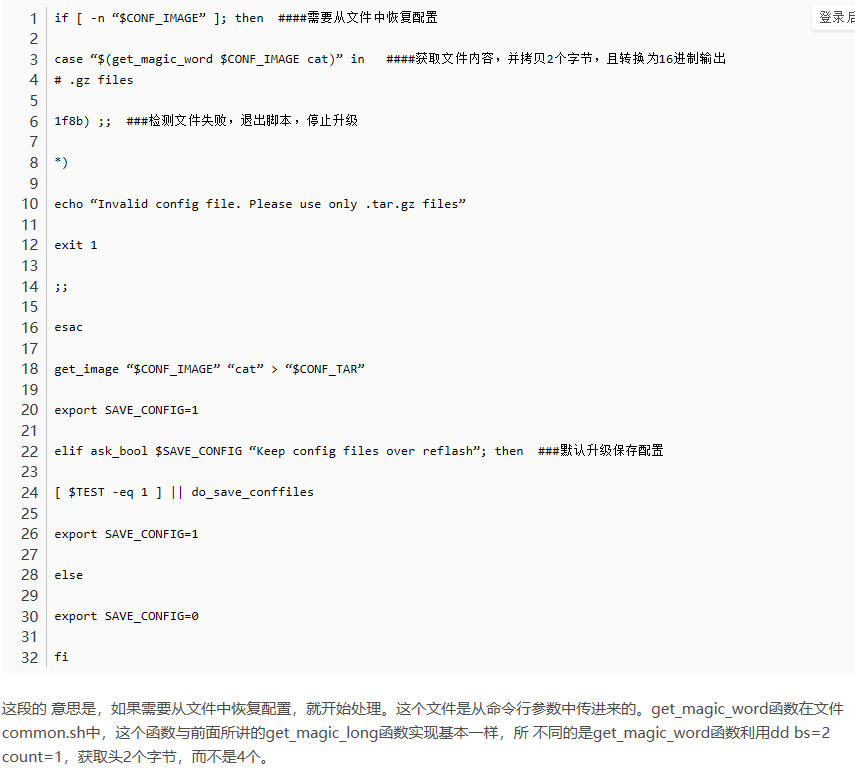

In [19]:
from IPython.display import Image
Image(filename='./sysupgrade8.png', width=1000, height=1000)

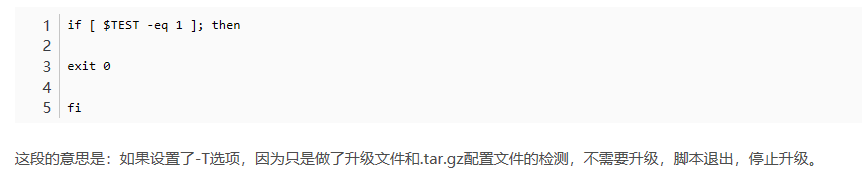

In [21]:
from IPython.display import Image
Image(filename='./sysupgrade9.png', width=800, height=800)

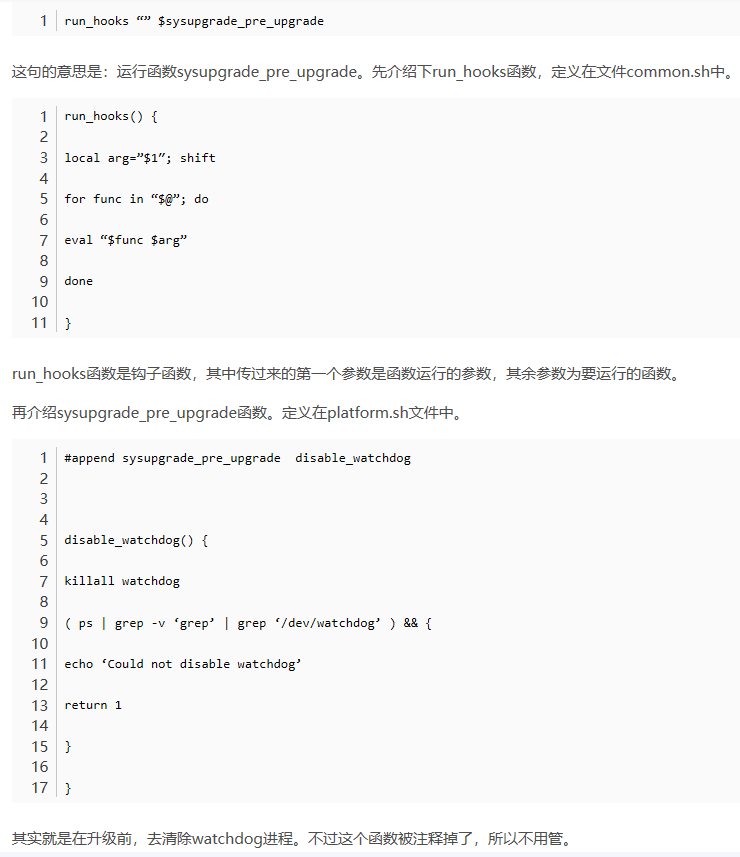

In [22]:
from IPython.display import Image
Image(filename='./sysupgrade10.png', width=800, height=800)

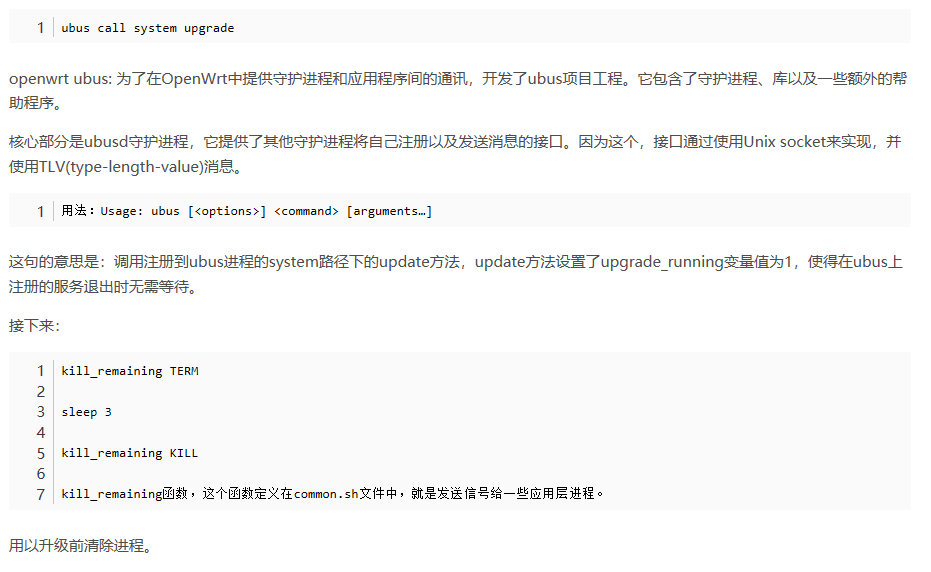

In [23]:
from IPython.display import Image
Image(filename='./sysupgrade11.png', width=800, height=800)

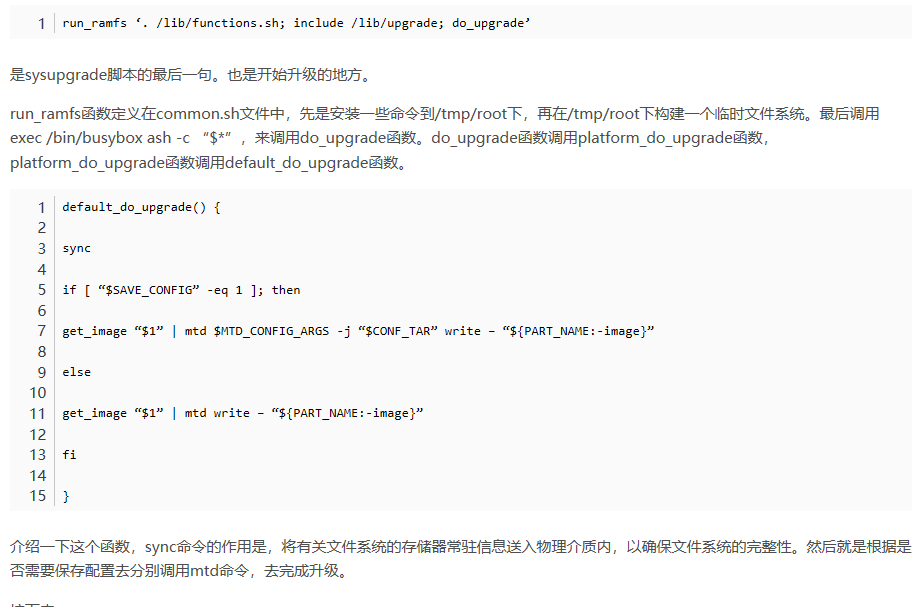

In [24]:
from IPython.display import Image
Image(filename='./sysupgrade12.png', width=800, height=800)

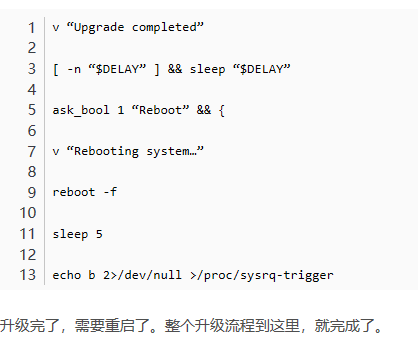

In [26]:
from IPython.display import Image
Image(filename='./sysupgrade13.png', width=500, height=500)

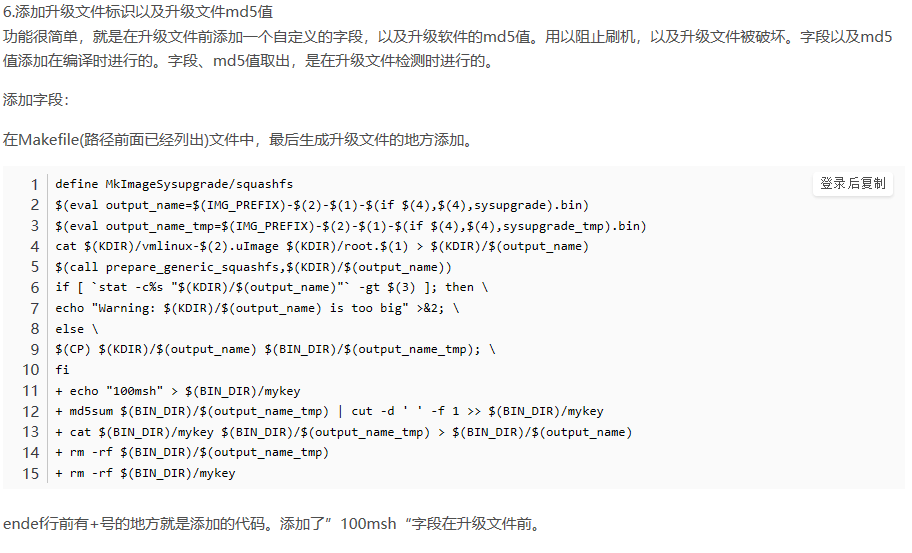

In [28]:
from IPython.display import Image
Image(filename='./sysupgrade14.png', width=1000, height=1000)

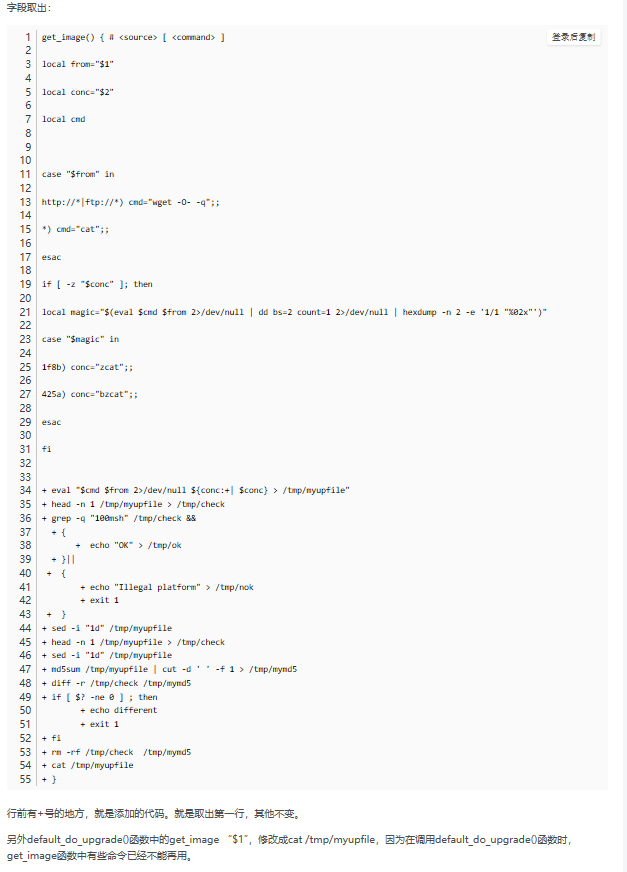

In [29]:
from IPython.display import Image
Image(filename='./sysupgrade15.png', width=1000, height=1000)